# 處理整體雜質 & 加入經緯度

In [2]:
# 加 車位別
# 加 單價平方公尺
# 放上去_bool ，原本只有 "float"、"int

In [3]:
import re
import pandas as pd

# 刪除整體雜質並存檔
df_train = pd.read_excel('train.xlsx')
df_valid = pd.read_excel('valid.xlsx')
df_test = pd.read_excel('test-reindex-test.xlsx')

df_train = df_train[([df_train['編號']] != 'serial number')&(df_train['交易標的'] != 'transaction sign')]

file = 'train' + '.csv'
df_train.to_csv(file, encoding='utf-8-sig', index=False, header=True)
file = 'valid' + '.csv'
df_valid.to_csv(file, encoding='utf-8-sig', index=False, header=True)
file = 'test' + '.csv'
df_test.to_csv(file, encoding='utf-8-sig', index=False, header=True)


df_train = pd.read_csv('train.csv')
df_valid = pd.read_csv('valid.csv')
df_test = pd.read_csv('test.csv')


# 提取縣市和鄉鎮市區
def extract_address(text):
    # 更新正則表達式，匹配以「市」或「縣」結尾的部分
    pattern = r"(?P<縣市>.+?[市縣])"
    match = re.match(pattern, text)
    if match:
        return match.group("縣市")
    else:
        return None


# 應用函數來切割地址，僅提取縣市和鄉鎮市區
df_train['縣市'] = df_train['土地位置建物門牌'].apply(extract_address)
df_valid['縣市'] = df_valid['土地位置建物門牌'].apply(extract_address)
df_test['縣市'] = df_test['土地位置建物門牌'].apply(extract_address)


# # 刪除地址格式錯誤資料
# df_train = df_train.drop(df_train[(df_train['縣市'].isna()) & (df_train['鄉鎮市區'].isna())].index)
# df_valid = df_valid.drop(df_valid[(df_valid['縣市'].isna()) & (df_valid['鄉鎮市區'].isna())].index)
# df_test = df_test.drop(df_test[(df_test['縣市'].isna()) & (df_test['鄉鎮市區'].isna())].index)      ### test 不能移除列


# file = 'train' + '_final' + '.csv'
# df_train.to_csv(file, encoding='utf-8-sig', index=False, header=True)
# file = 'valid' + '_final' + '.csv'
# df_valid.to_csv(file, encoding='utf-8-sig', index=False, header=True)
# file = 'test' + '_final' + '.csv'
# df_test.to_csv(file, encoding='utf-8-sig', index=False, header=True)

In [4]:
df_test[['縣市', '鄉鎮市區']]

,縣市,鄉鎮市區
0,彰化縣,社頭鄉
1,高雄市,小港區
2,新竹市,新竹市
3,新北市,淡水區
4,苗栗縣,頭份市
...,...,...
11990,桃園市,中壢區
11991,高雄市,前鎮區
11992,臺南市,東區
11993,新竹市,新竹市


# 檢查缺失值 並 處理

### 移除 不需要的欄位以及有缺值的欄位

In [10]:
# 不需要的欄位: 編號、土地位置建物門牌、有無管理組織 (不移除(暫定): '鄉鎮市區', '縣市')
# 不移除(暫定): 車位移轉總面積平方公尺  車位總價元、單價元平方公尺、車位類別
# 不移除(暫定): 都市土地使用分區、非都市土地使用分區、非都市土地使用編定、
# 建築完成年月、、備註、建案名稱、棟及號、解約情形
# 移轉層次、主要建材、主要用途: 1.很重要 2.缺值不多 ，所以不能刪  -> 要去補值 



def deleteCol(df):   
    df = df.drop(['編號', '有無管理組織', '土地位置建物門牌'], axis=1)
    df = df.drop(['建築完成年月', '備註', '建案名稱', '棟及號', '解約情形'], axis=1)         
    return df


df_train = deleteCol(df_train)
df_valid = deleteCol(df_valid)
df_test = deleteCol(df_test)

In [11]:

pre_col = ['總價元', 
            '鄉鎮市區',   # 最後處理
            '交易標的',   # label
            '土地移轉總面積平方公尺',   # 數值
            '都市土地使用分區',         # one hot 
            '非都市土地使用分區',       # one hot 
            '非都市土地使用編定',       # one hot 
            '交易年月日',              # 拆分 "年"、"月"、"日"
            '交易筆棟數',              # 拆分 "交易_土地數"、"交易_建築數"、"交易_車位數"
            '移轉層次',                # 國字轉數字
            '總樓層數',                # 數值
            '建物型態',                # one hot  
            '主要用途',                # one hot 
            '主要建材',                # one hot  
            '建物移轉總面積平方公尺',   # 數值
            '建物現況格局-房',          # 數值
            '建物現況格局-廳',          # 數值
            '建物現況格局-衛',          # 數值
            '建物現況格局-隔間',        # label
            '車位移轉總面積平方公尺',   # 數值
            '車位總價元',              # 數值
            '縣市'                     # 最後處理
            '單價元平方公尺',           # 數值
            '車位類別']                 # one hot

# 建立一個空的 DataFrame，並指定欄位名稱
pre_tr = pd.DataFrame(columns=pre_col)
pre_va = pd.DataFrame(columns=pre_col)
pre_tt = pd.DataFrame(columns=pre_col)

pre_tt = pre_tt.drop(['總價元'], axis=1)

pre_tr = df_train.copy()
pre_va = df_valid.copy()
pre_tt = df_test.copy()

pre_tr.shape

(455784, 24)

In [12]:
print(pre_tr['都市土地使用分區'].unique())
print(pre_va['都市土地使用分區'].unique())
print(pre_tt['都市土地使用分區'].unique())

print(pre_tr['非都市土地使用分區'].unique())
print(pre_va['非都市土地使用分區'].unique())
print(pre_tt['非都市土地使用分區'].unique())

print(pre_tr['非都市土地使用編定'].unique())
print(pre_va['非都市土地使用編定'].unique())
print(pre_tt['非都市土地使用編定'].unique())

['其他' '商' '住' nan '工' '農']
['住' '商' '其他' nan '工' '農']
['住' '商' '其他' nan '工' '農']
[nan '特定農業區' '鄉村區' '一般農業區' '山坡地保育區' '工業區' '特定專用區' '風景區']
[nan '鄉村區' '一般農業區' '山坡地保育區' '特定農業區' '工業區' '特定專用區']
[nan '鄉村區' '山坡地保育區' '特定農業區' '一般農業區' '工業區' '特定專用區']
[nan '甲種建築用地' '乙種建築用地' '丙種建築用地' '農牧用地' '丁種建築用地' '國土保安用地' '林業用地' '特定目的事業用地']
[nan '乙種建築用地' '甲種建築用地' '丙種建築用地' '丁種建築用地' '農牧用地' '國土保安用地']
[nan '乙種建築用地' '丙種建築用地' '甲種建築用地' '農牧用地' '國土保安用地' '丁種建築用地' '林業用地']


In [13]:

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()


# 交易標的
pre_tr['交易標的'] = label_encoder.fit_transform(pre_tr['交易標的'])
pre_va['交易標的'] = label_encoder.fit_transform(pre_va['交易標的'])
pre_tt['交易標的'] = label_encoder.fit_transform(pre_tt['交易標的'])



In [14]:

import pandas as pd

# 先將欄位轉換為字串類型，確保不會出現浮點數拼接字串的錯誤
pre_tr['都市土地使用分區'] = pre_tr['都市土地使用分區'].astype(str)
pre_va['都市土地使用分區'] = pre_va['都市土地使用分區'].astype(str)
pre_tt['都市土地使用分區'] = pre_tt['都市土地使用分區'].astype(str)

pre_tr['非都市土地使用分區'] = pre_tr['非都市土地使用分區'].astype(str)
pre_va['非都市土地使用分區'] = pre_va['非都市土地使用分區'].astype(str)
pre_tt['非都市土地使用分區'] = pre_tt['非都市土地使用分區'].astype(str)

pre_tr['非都市土地使用編定'] = pre_tr['非都市土地使用編定'].astype(str)
pre_va['非都市土地使用編定'] = pre_va['非都市土地使用編定'].astype(str)
pre_tt['非都市土地使用編定'] = pre_tt['非都市土地使用編定'].astype(str)

# 取得所有資料集的完整類別集合
all_categories1 = set(pre_tr['都市土地使用分區']).union(set(pre_va['都市土地使用分區'])).union(set(pre_tt['都市土地使用分區']))
all_categories2 = set(pre_tr['非都市土地使用分區']).union(set(pre_va['非都市土地使用分區'])).union(set(pre_tt['非都市土地使用分區']))
all_categories3 = set(pre_tr['非都市土地使用編定']).union(set(pre_va['非都市土地使用編定'])).union(set(pre_tt['非都市土地使用編定']))


# 都市土地使用分區
pre_tr1 = pd.get_dummies(pre_tr['都市土地使用分區'],  prefix='都市土地使用分區').reindex(columns=['都市土地使用分區_' + cat for cat in all_categories1], fill_value=0)
pre_va1 = pd.get_dummies(pre_va['都市土地使用分區'],  prefix='都市土地使用分區').reindex(columns=['都市土地使用分區_' + cat for cat in all_categories1], fill_value=0)
pre_tt1 = pd.get_dummies(pre_tt['都市土地使用分區'],  prefix='都市土地使用分區').reindex(columns=['都市土地使用分區_' + cat for cat in all_categories1], fill_value=0)

# 非都市土地使用分區
pre_tr2 = pd.get_dummies(pre_tr['非都市土地使用分區'], prefix='非都市土地使用分區').reindex(columns=['非都市土地使用分區_' + cat for cat in all_categories2], fill_value=0)
pre_va2 = pd.get_dummies(pre_va['非都市土地使用分區'], prefix='非都市土地使用分區').reindex(columns=['非都市土地使用分區_' + cat for cat in all_categories2], fill_value=0)
pre_tt2 = pd.get_dummies(pre_tt['非都市土地使用分區'], prefix='非都市土地使用分區').reindex(columns=['非都市土地使用分區_' + cat for cat in all_categories2], fill_value=0)

# 非都市土地使用編定
pre_tr3 = pd.get_dummies(pre_tr['非都市土地使用編定'], prefix='非都市土地使用編定').reindex(columns=['非都市土地使用編定_' + cat for cat in all_categories3], fill_value=0)
pre_va3 = pd.get_dummies(pre_va['非都市土地使用編定'], prefix='非都市土地使用編定').reindex(columns=['非都市土地使用編定_' + cat for cat in all_categories3], fill_value=0)
pre_tt3 = pd.get_dummies(pre_tt['非都市土地使用編定'], prefix='非都市土地使用編定').reindex(columns=['非都市土地使用編定_' + cat for cat in all_categories3], fill_value=0)



# 合併所有編碼後的結果
pre_tr = pd.concat([pre_tr, pre_tr1, pre_tr2, pre_tr3], axis=1)
pre_va = pd.concat([pre_va, pre_va1, pre_va2, pre_va3], axis=1)
pre_tt = pd.concat([pre_tt, pre_tt1, pre_tt2, pre_tt3], axis=1)

pre_tr = pre_tr.drop(['都市土地使用分區', '非都市土地使用分區', '非都市土地使用編定'], axis=1)
pre_va = pre_va.drop(['都市土地使用分區', '非都市土地使用分區', '非都市土地使用編定'], axis=1)
pre_tt = pre_tt.drop(['都市土地使用分區', '非都市土地使用分區', '非都市土地使用編定'], axis=1)


pre_tr = pre_tr.drop(['都市土地使用分區_nan', '非都市土地使用分區_nan', '非都市土地使用編定_nan'], axis=1)
pre_va = pre_va.drop(['都市土地使用分區_nan', '非都市土地使用分區_nan', '非都市土地使用編定_nan'], axis=1)
pre_tt = pre_tt.drop(['都市土地使用分區_nan', '非都市土地使用分區_nan', '非都市土地使用編定_nan'], axis=1)

In [15]:
# pre_tr.columns
# pre_tr.head()

In [16]:
import pandas as pd

# 定義處理函數
def split_date(df):
    def convert_to_date(ymd):
        ymd_str = str(ymd)
        
        # 檢查長度是否為6或7位數
        if len(ymd_str) == 7:
            year = int(ymd_str[:3])  # 取前三位為年
            month = int(ymd_str[3:5])
            day = int(ymd_str[5:])
        elif len(ymd_str) == 6:
            year = int(ymd_str[:2])  # 取前兩位為年
            month = int(ymd_str[2:4])
            day = int(ymd_str[4:])
        else:
            return pd.Series([None, None, None])  # 錯誤格式
        
        # 處理民國年轉換
        if 99 <= year <= 113:
            year += 1911
        elif 11 <= year <= 98:  # 針對6位數民國年轉換（例如民國91年）
            year += 1911
        else:
            return pd.Series([None, None, None])  # 年份不正確

        return pd.Series([year, month, day])

    # 使用 apply 來處理每個欄位的數據
    df[['交易_年', '交易_月', '交易_日']] = df['交易年月日'].apply(convert_to_date)

    df = df[df['交易_年'] >= 2010]
    df = df.dropna(subset=['交易_年'])

    return df


# 應用到訓練集、驗證集和測試集
pre_tr = split_date(pre_tr)
pre_va = split_date(pre_va)
pre_tt = split_date(pre_tt)

# # 合併所有編碼後的結果
# pre_tr = pd.concat([pre_tr, pre_tr1], axis=1)
# pre_va = pd.concat([pre_va, pre_va1], axis=1)
# pre_tt = pd.concat([pre_tt, pre_tt1], axis=1)


pre_tr = pre_tr.drop(['交易年月日'], axis=1)
pre_va = pre_va.drop(['交易年月日'], axis=1)
pre_tt = pre_tt.drop(['交易年月日'], axis=1)


label encoding

In [18]:
import re

# 交易筆棟數 
def extract_numbers(text):
    numbers = re.findall(r'\d+', text)
    # 如果找到的數字少於 3 個，補上 '0' 來保持長度一致
    while len(numbers) < 3:
        numbers.append('0')

    # 確保只返回 3 個數字
    return pd.Series([int(num) for num in numbers[:3]]) 

def SplitCol(df):
    # 應用這個函數來處理 '建物型態' 欄位
    df[['交易_土地數', '交易_建物數', '交易_車位數']] = df['交易筆棟數'].apply(extract_numbers)
    # 移除 '交易筆棟數'
    # df = df.drop(['交易筆棟數'], axis=1)

    return df

# 應用到訓練集、驗證集和測試集
pre_tr = SplitCol(pre_tr)
pre_va = SplitCol(pre_va)
pre_tt = SplitCol(pre_tt)

# # 合併所有編碼後的結果
# pre_tr = pd.concat([pre_tr, pre_tr1], axis=1)
# pre_va = pd.concat([pre_va, pre_va1], axis=1)
# pre_tt = pd.concat([pre_tt, pre_tt1], axis=1)

pre_tr = pre_tr.drop(['交易筆棟數'], axis=1)
pre_va = pre_va.drop(['交易筆棟數'], axis=1)
pre_tt = pre_tt.drop(['交易筆棟數'], axis=1)


In [19]:
print(pre_tr.columns)
pre_tr[['交易_土地數', '交易_建物數', '交易_車位數']]
# pre_tr.head()

Index(['總價元', '鄉鎮市區', '交易標的', '土地移轉總面積平方公尺', '移轉層次', '總樓層數', '建物型態', '主要用途',
       '主要建材', '建物移轉總面積平方公尺', '建物現況格局-房', '建物現況格局-廳', '建物現況格局-衛', '建物現況格局-隔間',
       '單價元平方公尺', '車位類別', '車位移轉總面積平方公尺', '車位總價元', '縣市', '都市土地使用分區_商',
       '都市土地使用分區_工', '都市土地使用分區_其他', '都市土地使用分區_農', '都市土地使用分區_住',
       '非都市土地使用分區_風景區', '非都市土地使用分區_山坡地保育區', '非都市土地使用分區_特定專用區',
       '非都市土地使用分區_特定農業區', '非都市土地使用分區_鄉村區', '非都市土地使用分區_工業區', '非都市土地使用分區_一般農業區',
       '非都市土地使用編定_林業用地', '非都市土地使用編定_乙種建築用地', '非都市土地使用編定_特定目的事業用地',
       '非都市土地使用編定_農牧用地', '非都市土地使用編定_丁種建築用地', '非都市土地使用編定_國土保安用地',
       '非都市土地使用編定_丙種建築用地', '非都市土地使用編定_甲種建築用地', '交易_年', '交易_月', '交易_日',
       '交易_土地數', '交易_建物數', '交易_車位數'],
      dtype='object')


,交易_土地數,交易_建物數,交易_車位數
0,1,1,1
1,1,1,1
2,3,1,1
3,2,1,1
4,1,1,1
...,...,...,...
455779,1,1,1
455780,28,1,1
455781,6,1,1
455782,1,1,1


In [20]:
# 移轉層次
def floor(df):
    # 定義中文樓層到數字的映射字典
    floor_mapping = {
        "一層": 1, "二層": 2, "三層": 3, "四層": 4, "五層": 5, "六層": 6, "七層": 7, "八層": 8, "九層": 9, "十層": 10,
        "十一層": 11, "十二層": 12, "十三層": 13, "十四層": 14, "十五層": 15, "十六層": 16, "十七層": 17, "十八層": 18, "十九層": 19, "二十層": 20,
        "二十一層": 21, "二十二層": 22, "二十三層": 23, "二十四層": 24, "二十五層": 25, "二十六層": 26, "二十七層": 27, "二十八層": 28, "二十九層": 29, "三十層": 30,
        "三十一層": 31, "三十二層": 32, "三十三層": 33, "三十四層": 34, "三十五層": 35, "三十六層": 36, "三十七層": 37, "三十八層": 38, "三十九層": 39, "四十層": 40,
        "四十一層": 41, "四十二層": 42, "四十三層": 43, "四十四層": 44, "四十五層": 45, "四十六層": 46, "四十七層": 47, "四十八層": 48, "四十九層": 49, "五十層": 50,
        "五十一層": 51, "五十二層": 52, "五十三層": 53, "五十四層": 54, "五十五層": 55, "五十六層": 56, "五十七層": 57, "五十八層": 58, "五十九層": 59, "六十層": 60,
        "六十一層": 61, "六十二層": 62, "六十三層": 63, "六十四層": 64, "六十五層": 65, "六十六層": 66, "六十七層": 67, "六十八層": 68, "六十九層": 69, "七十層": 70
    }


    # 使用 apply 函數來將移轉層次欄位的中文樓層替換為對應的數字
    df['移轉層次'] = df.apply(
        lambda row: row['總樓層數'] if row['移轉層次'] == '全' 
        else floor_mapping[row['移轉層次']] 
        if row['移轉層次'] in floor_mapping 
        else -1, 
        axis = 1
    )
        
    return df

pre_tr = floor(pre_tr)
pre_va = floor(pre_va)
pre_tt = floor(pre_tt)


In [22]:
import pandas as pd

# 先將欄位轉換為字串類型，確保不會出現浮點數拼接字串的錯誤
pre_tr['建物型態'] = pre_tr['建物型態'].astype(str).str.strip()
pre_va['建物型態'] = pre_va['建物型態'].astype(str).str.strip()
pre_tt['建物型態'] = pre_tt['建物型態'].astype(str).str.strip()

pre_tr['主要用途'] = pre_tr['主要用途'].astype(str).str.strip()
pre_va['主要用途'] = pre_va['主要用途'].astype(str).str.strip()
pre_tt['主要用途'] = pre_tt['主要用途'].astype(str).str.strip()

pre_tr['主要建材'] = pre_tr['主要建材'].astype(str).str.strip()
pre_va['主要建材'] = pre_va['主要建材'].astype(str).str.strip()
pre_tt['主要建材'] = pre_tt['主要建材'].astype(str).str.strip()

# 取得所有資料集的"建物型態"、"主要用途"和"主要建材"類別
all_categories1 = set(pre_tr['建物型態']).union(set(pre_va['建物型態'])).union(set(pre_tt['建物型態']))
all_categories2 = set(pre_tr['主要用途']).union(set(pre_va['主要用途'])).union(set(pre_tt['主要用途']))
all_categories3 = set(pre_tr['主要建材']).union(set(pre_va['主要建材'])).union(set(pre_tt['主要建材']))

# 對"建物型態"進行One-Hot Encoding，並補齊缺失的類別
pre_tr1 = pd.get_dummies(pre_tr['建物型態'], prefix='建物型態').reindex(columns=['建物型態_' + cat for cat in all_categories1], fill_value=0)
pre_va1 = pd.get_dummies(pre_va['建物型態'], prefix='建物型態').reindex(columns=['建物型態_' + cat for cat in all_categories1], fill_value=0)
pre_tt1 = pd.get_dummies(pre_tt['建物型態'], prefix='建物型態').reindex(columns=['建物型態_' + cat for cat in all_categories1], fill_value=0)

# 對"主要用途"進行One-Hot Encoding，並補齊缺失的類別
pre_tr2 = pd.get_dummies(pre_tr['主要用途'], prefix='主要用途').reindex(columns=['主要用途_' + cat for cat in all_categories2], fill_value=0)
pre_va2 = pd.get_dummies(pre_va['主要用途'], prefix='主要用途').reindex(columns=['主要用途_' + cat for cat in all_categories2], fill_value=0)
pre_tt2 = pd.get_dummies(pre_tt['主要用途'], prefix='主要用途').reindex(columns=['主要用途_' + cat for cat in all_categories2], fill_value=0)

# 對"主要建材"進行One-Hot Encoding，並補齊缺失的類別
pre_tr3 = pd.get_dummies(pre_tr['主要建材'], prefix='主要建材').reindex(columns=['主要建材_' + cat for cat in all_categories3], fill_value=0)
pre_va3 = pd.get_dummies(pre_va['主要建材'], prefix='主要建材').reindex(columns=['主要建材_' + cat for cat in all_categories3], fill_value=0)
pre_tt3 = pd.get_dummies(pre_tt['主要建材'], prefix='主要建材').reindex(columns=['主要建材_' + cat for cat in all_categories3], fill_value=0)

# 合併所有編碼後的結果
pre_tr = pd.concat([pre_tr, pre_tr1, pre_tr2, pre_tr3], axis=1)
pre_va = pd.concat([pre_va, pre_va1, pre_va2, pre_va3], axis=1)
pre_tt = pd.concat([pre_tt, pre_tt1, pre_tt2, pre_tt3], axis=1)

# 刪除原始的 "建物型態", "主要用途", "主要建材" 欄位
pre_tr = pre_tr.drop(['建物型態', '主要用途', '主要建材'], axis=1)
pre_va = pre_va.drop(['建物型態', '主要用途', '主要建材'], axis=1)
pre_tt = pre_tt.drop(['建物型態', '主要用途', '主要建材'], axis=1)


# 刪除原始的 "建物型態", "主要用途", "主要建材" 欄位
pre_tr = pre_tr.drop(['主要用途_nan', '主要建材_nan'], axis=1)
pre_va = pre_va.drop(['主要用途_nan', '主要建材_nan'], axis=1)
pre_tt = pre_tt.drop(['主要用途_nan', '主要建材_nan'], axis=1)

In [23]:
print(pre_tr.columns)
pre_tr.head()

Index(['總價元', '鄉鎮市區', '交易標的', '土地移轉總面積平方公尺', '移轉層次', '總樓層數', '建物移轉總面積平方公尺',
       '建物現況格局-房', '建物現況格局-廳', '建物現況格局-衛', '建物現況格局-隔間', '單價元平方公尺', '車位類別',
       '車位移轉總面積平方公尺', '車位總價元', '縣市', '都市土地使用分區_商', '都市土地使用分區_工', '都市土地使用分區_其他',
       '都市土地使用分區_農', '都市土地使用分區_住', '非都市土地使用分區_風景區', '非都市土地使用分區_山坡地保育區',
       '非都市土地使用分區_特定專用區', '非都市土地使用分區_特定農業區', '非都市土地使用分區_鄉村區', '非都市土地使用分區_工業區',
       '非都市土地使用分區_一般農業區', '非都市土地使用編定_林業用地', '非都市土地使用編定_乙種建築用地',
       '非都市土地使用編定_特定目的事業用地', '非都市土地使用編定_農牧用地', '非都市土地使用編定_丁種建築用地',
       '非都市土地使用編定_國土保安用地', '非都市土地使用編定_丙種建築用地', '非都市土地使用編定_甲種建築用地', '交易_年',
       '交易_月', '交易_日', '交易_土地數', '交易_建物數', '交易_車位數', '建物型態_農舍', '建物型態_工廠',
       '建物型態_廠辦', '建物型態_倉庫', '建物型態_店面(店鋪)', '建物型態_公寓(5樓含以下無電梯)', '建物型態_辦公商業大樓',
       '建物型態_透天厝', '建物型態_其他', '建物型態_套房(1房1廳1衛)', '建物型態_華廈(10層含以下有電梯)',
       '建物型態_住宅大樓(11層含以上有電梯)', '主要用途_見其它登記事項', '主要用途_農業用', '主要用途_見使用執照',
       '主要用途_商業用', '主要用途_見其他登記事項', '主要用途_國民住宅', '主要用途_住工用', '主要用途_工業用',
       '主要用途_住家用', '主要用途_住商用', '主要用途_工商用'

,總價元,鄉鎮市區,交易標的,土地移轉總面積平方公尺,移轉層次,總樓層數,建物移轉總面積平方公尺,建物現況格局-房,建物現況格局-廳,建物現況格局-衛,...,主要建材_見其他登記事項,主要建材_鋼筋混凝土構造,主要建材_鋼骨鋼筋混凝土造,主要建材_預力混凝土造,主要建材_石造,主要建材_鋼筋混凝土造,主要建材_木造,主要建材_鋼造,主要建材_鋼骨混凝土造,主要建材_混凝土造
0,28770000,西屯區,2,9.58,16,36,141.69,3,2,2,...,True,False,False,False,False,False,False,False,False,False
1,13860000,大園區,2,13.52,18,23,100.13,2,2,1,...,False,False,False,False,False,True,False,False,False,False
2,13950000,南區,2,15.94,10,11,115.84,2,2,2,...,False,False,False,False,False,True,False,False,False,False
3,13990000,左營區,2,4.95,24,34,117.38,3,1,1,...,True,False,False,False,False,False,False,False,False,False
4,6810000,竹東鎮,2,24.67,9,14,155.79,3,2,2,...,False,False,False,False,False,True,False,False,False,False


In [24]:
# 建物現況格局-隔間
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

pre_tr['建物現況格局-隔間'] = label_encoder.fit_transform(pre_tr['建物現況格局-隔間'])
pre_va['建物現況格局-隔間'] = label_encoder.fit_transform(pre_va['建物現況格局-隔間'])
pre_tt['建物現況格局-隔間'] = label_encoder.fit_transform(pre_tt['建物現況格局-隔間'])


In [25]:
print(pre_tr.columns)
pre_tr['建物現況格局-隔間']
# pre_tr.head()

Index(['總價元', '鄉鎮市區', '交易標的', '土地移轉總面積平方公尺', '移轉層次', '總樓層數', '建物移轉總面積平方公尺',
       '建物現況格局-房', '建物現況格局-廳', '建物現況格局-衛', '建物現況格局-隔間', '單價元平方公尺', '車位類別',
       '車位移轉總面積平方公尺', '車位總價元', '縣市', '都市土地使用分區_商', '都市土地使用分區_工', '都市土地使用分區_其他',
       '都市土地使用分區_農', '都市土地使用分區_住', '非都市土地使用分區_風景區', '非都市土地使用分區_山坡地保育區',
       '非都市土地使用分區_特定專用區', '非都市土地使用分區_特定農業區', '非都市土地使用分區_鄉村區', '非都市土地使用分區_工業區',
       '非都市土地使用分區_一般農業區', '非都市土地使用編定_林業用地', '非都市土地使用編定_乙種建築用地',
       '非都市土地使用編定_特定目的事業用地', '非都市土地使用編定_農牧用地', '非都市土地使用編定_丁種建築用地',
       '非都市土地使用編定_國土保安用地', '非都市土地使用編定_丙種建築用地', '非都市土地使用編定_甲種建築用地', '交易_年',
       '交易_月', '交易_日', '交易_土地數', '交易_建物數', '交易_車位數', '建物型態_農舍', '建物型態_工廠',
       '建物型態_廠辦', '建物型態_倉庫', '建物型態_店面(店鋪)', '建物型態_公寓(5樓含以下無電梯)', '建物型態_辦公商業大樓',
       '建物型態_透天厝', '建物型態_其他', '建物型態_套房(1房1廳1衛)', '建物型態_華廈(10層含以下有電梯)',
       '建物型態_住宅大樓(11層含以上有電梯)', '主要用途_見其它登記事項', '主要用途_農業用', '主要用途_見使用執照',
       '主要用途_商業用', '主要用途_見其他登記事項', '主要用途_國民住宅', '主要用途_住工用', '主要用途_工業用',
       '主要用途_住家用', '主要用途_住商用', '主要用途_工商用'

0         0
1         0
2         0
3         0
4         0
         ..
455779    0
455780    0
455781    0
455782    0
455783    0
Name: 建物現況格局-隔間, Length: 455776, dtype: int32

In [26]:
print(pre_tr['車位類別'].unique())
print(pre_va['車位類別'].unique())
print(pre_tt['車位類別'].unique())

['坡道平面' nan '塔式車位' '坡道機械' '升降機械' '升降平面' '一樓平面' '其他']
[nan '坡道平面' '一樓平面' '坡道機械' '升降機械' '其他' '升降平面' '塔式車位']
[nan '坡道平面' '坡道機械' '一樓平面' '升降平面' '升降機械' '塔式車位' '其他']


In [27]:
# 車位類別

# 先將欄位轉換為字串類型，確保不會出現浮點數拼接字串的錯誤
pre_tr['車位類別'] = pre_tr['車位類別'].astype(str).str.strip()
pre_va['車位類別'] = pre_va['車位類別'].astype(str).str.strip()
pre_tt['車位類別'] = pre_tt['車位類別'].astype(str).str.strip()


# 取得所有資料集的"建物型態"、"主要用途"和"主要建材"類別
all_categories1 = set(pre_tr['車位類別']).union(set(pre_va['車位類別'])).union(set(pre_tt['車位類別']))

# 對"建物型態"進行One-Hot Encoding，並補齊缺失的類別
pre_tr1 = pd.get_dummies(pre_tr['車位類別'], prefix='車位類別').reindex(columns=['車位類別_' + cat for cat in all_categories1], fill_value=0)
pre_va1 = pd.get_dummies(pre_va['車位類別'], prefix='車位類別').reindex(columns=['車位類別_' + cat for cat in all_categories1], fill_value=0)
pre_tt1 = pd.get_dummies(pre_tt['車位類別'], prefix='車位類別').reindex(columns=['車位類別_' + cat for cat in all_categories1], fill_value=0)

# 合併所有編碼後的結果
pre_tr = pd.concat([pre_tr, pre_tr1], axis=1)
pre_va = pd.concat([pre_va, pre_va1], axis=1)
pre_tt = pd.concat([pre_tt, pre_tt1], axis=1)

# 刪除原始的 "建物型態", "主要用途", "主要建材" 欄位
pre_tr = pre_tr.drop(['車位類別'], axis=1)
pre_va = pre_va.drop(['車位類別'], axis=1)
pre_tt = pre_tt.drop(['車位類別'], axis=1)

# 刪除原始的 "建物型態", "主要用途", "主要建材" 欄位
pre_tr = pre_tr.drop(['車位類別_nan', '車位類別_nan'], axis=1)
pre_va = pre_va.drop(['車位類別_nan', '車位類別_nan'], axis=1)
pre_tt = pre_tt.drop(['車位類別_nan', '車位類別_nan'], axis=1)

In [28]:

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# 縣市
pre_tr['縣市'] = label_encoder.fit_transform(pre_tr['縣市'])
pre_va['縣市'] = label_encoder.fit_transform(pre_va['縣市'])
pre_tt['縣市'] = label_encoder.fit_transform(pre_tt['縣市'])


# 鄉鎮市區
pre_tr['鄉鎮市區'] = label_encoder.fit_transform(pre_tr['鄉鎮市區'])
pre_va['鄉鎮市區'] = label_encoder.fit_transform(pre_va['鄉鎮市區'])
pre_tt['鄉鎮市區'] = label_encoder.fit_transform(pre_tt['鄉鎮市區'])



## 相關係數圖表

<Axes: >

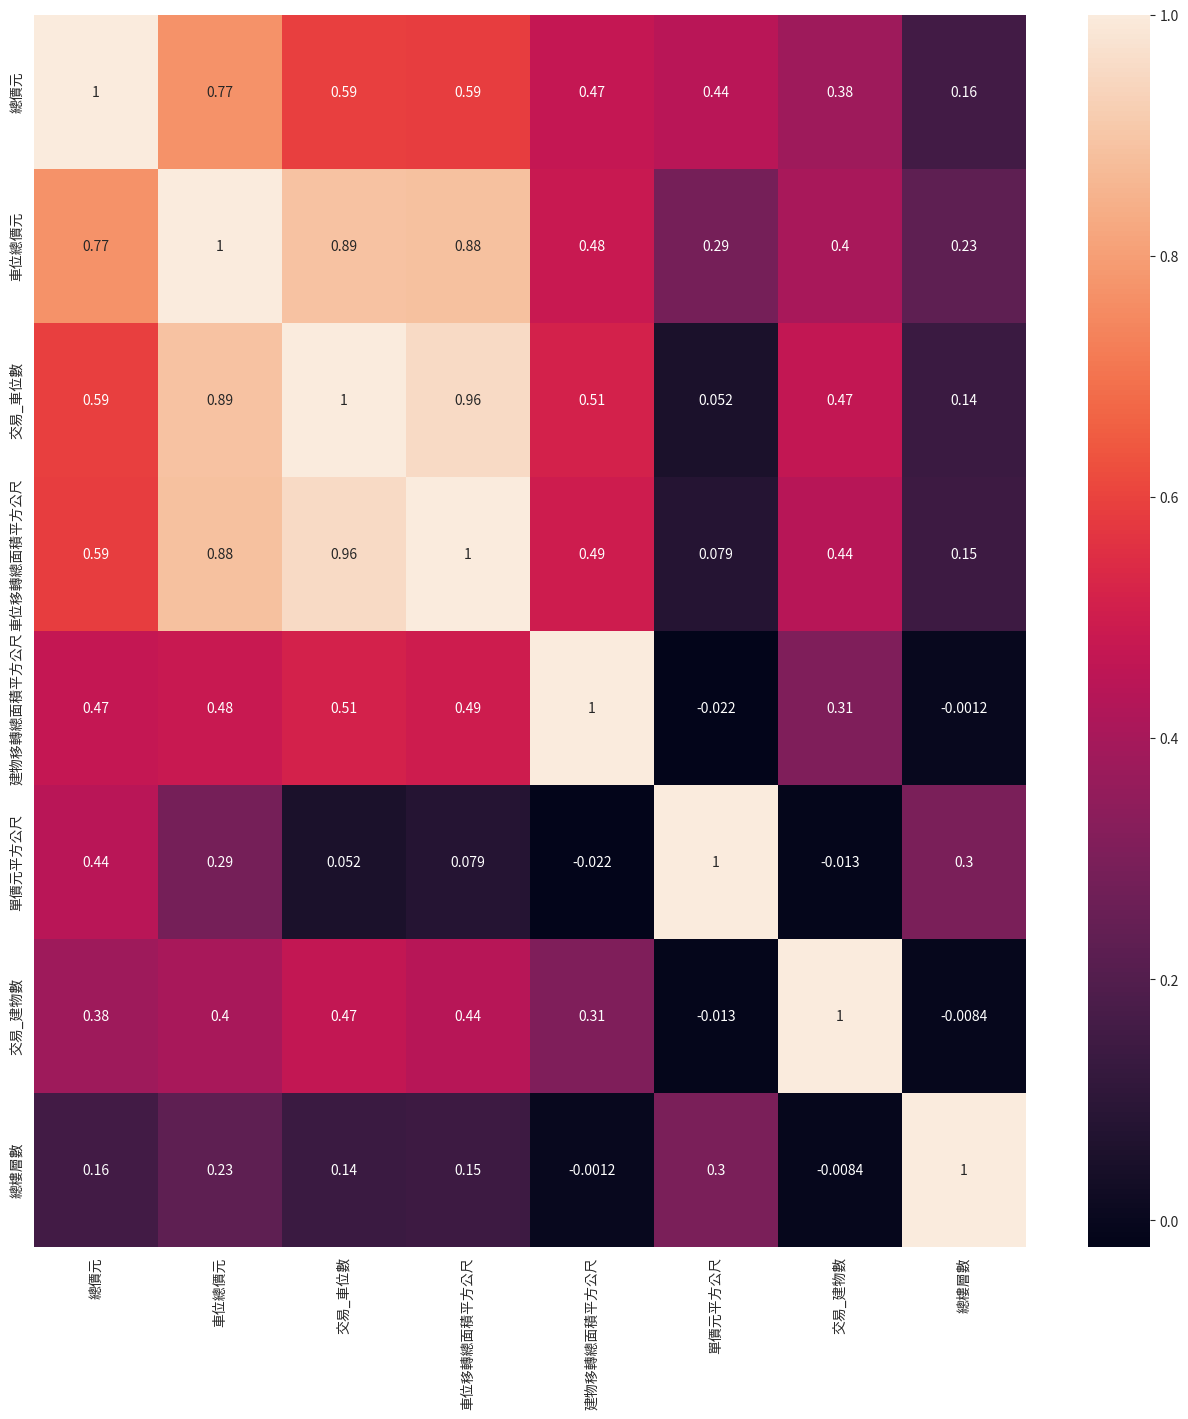

In [38]:
# 中文亂碼問題
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid', {"font.sans-serif":['Taipei Sans TC Beta']})

import matplotlib.pyplot as plt

# 所有特徵之間的相關關係
numeric_columns = pre_tr.select_dtypes(include=['float64', 'int64', 'boolean'])
corrs = numeric_columns.corr()

cols_10 = corrs.nlargest(8, '總價元')['總價元'].index
corrs_10 = pre_tr[cols_10].corr()
plt.figure(figsize=(8, 8))
sns.heatmap(corrs_10, annot=True)

## 隨機森林訓練模型

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import pandas as pd

# # 取前10名作為特徵
numeric_columns = pre_tr.select_dtypes(include=['float64', 'int64', 'boolean'])
corrs = numeric_columns.corr()
cols_10 = corrs.nlargest(8, '總價元')['總價元'].index
cols_10 = cols_10.drop('總價元')

# 將資料分成 X 和 y
X_train = pre_tr[cols_10]   # 替換成實際的特徵欄位
y_train = pre_tr['總價元']  # 替換成你的目標變數

X_valid = pre_va[cols_10]  # 替換成實際的特徵欄位
y_valid = pre_va['總價元']  # 替換成你的目標變數

X_test = pre_tt[cols_10] # 替換成實際的特徵欄位

# 初始化標準化工具
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# 對 X 和 y 進行標準化
X_train_scaled = scaler_X.fit_transform(X_train)
X_valid_scaled = scaler_X.transform(X_valid)
X_test_scaled = scaler_X.transform(X_test)

# 對 y 進行標準化 (注意 reshape 因為 y 是一維的)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_valid_scaled = scaler_y.transform(y_valid.values.reshape(-1, 1))

# 定義隨機森林回歸模型
model = RandomForestRegressor(random_state=42)

# # 定義參數網格
# param_grid = {
#     'n_estimators': [100, 200, 300],    # 樹的數量
#     'max_depth': [10, 20, 30, None],    # 樹的最大深度
#     'min_samples_split': [2, 5, 10],    # 分裂節點的最小樣本數
#     'min_samples_leaf': [1, 2, 4]       # 葉節點的最小樣本數
# }

# 定義參數網格
param_grid = {
    'n_estimators': [100],    # 樹的數量
    'max_depth': [None],    # 樹的最大深度
    'min_samples_split': [2],    # 分裂節點的最小樣本數
    'min_samples_leaf': [1]       # 葉節點的最小樣本數
}



# 使用 GridSearchCV 來搜尋最佳參數
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# 訓練模型並進行超參數搜索
grid_search.fit(X_train_scaled, y_train_scaled.ravel())

# 獲取最佳參數
best_params = grid_search.best_params_
print(f"最佳參數: {best_params}")

# 使用最佳參數重新訓練模型
best_model = grid_search.best_estimator_



# 在驗證集上進行預測
y_valid_pred_scaled = best_model.predict(X_valid_scaled)

# 將預測結果反標準化回原尺度
y_valid_pred = scaler_y.inverse_transform(y_valid_pred_scaled.reshape(-1, 1))

# 評估模型表現
mse = mean_squared_error(y_valid, y_valid_pred)
r2 = r2_score(y_valid, y_valid_pred)
print(f'驗證集上的均方誤差 (MSE): {mse}')
print(f'驗證集上的決定係數 (R²): {r2}')

# 對測試集進行預測
y_test_pred_scaled = best_model.predict(X_test_scaled)

# 將測試集預測結果反標準化回原尺度
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1))

# 查看部分預測結果
print("測試集的預測結果: ", y_test_pred[:5])


最佳參數: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
驗證集上的均方誤差 (MSE): 456302297904.5563
驗證集上的決定係數 (R²): 0.9971308736599048
測試集的預測結果:  [[ 9501599.99999999]
 [ 6241500.        ]
 [14878800.        ]
 [13704300.        ]
 [13392200.        ]]


## write 預測結果

In [39]:

# 創建一個 DataFrame 保存測試集的預測房價
test_predictions = pd.DataFrame({
    '編號': pre_tt.index+1,  # 假設你有一個 'Id' 欄位或索引來唯一標識每個房屋
    '總價元': y_test_pred.ravel()  # 展平成一維數組
})

# 保存預測結果到 CSV 文件
test_predictions.to_csv('house_price_predictions_HW01.csv', encoding='utf-8-sig', index=False, header=True)



# # 924074.9634 目前最好